In [264]:
%matplotlib inline

from metapool.metapool import *

# Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate. 

The workflow then:
1. reads in the plate map and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

In [279]:
# Step 1: read in plate map

plate_df = read_plate_map_csv(open('./test_data/MRSA/Map/MRSA_sample_map.txt','r'))

# Step 2: read in DNA concentrations and add to plate map

sample_concs = read_pico_csv(open('./test_data/MRSA/Quant/MiniPico/2017-08-01_MRSA_1-4.txt','r'))
plate_df = pd.merge(plate_df, sample_concs, on='Well')

# Step 3: calculate volumes and add to plate map
dna_vols = calculate_norm_vol(plate_df['Sample DNA Concentration'], ng=5, min_vol=2.5, max_vol=3500, resolution=2.5)
water_vols = 3500 - dna_vols
plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

# Step 4: make pick list
obs_picklist = format_dna_norm_picklist(np.array(plate_df['Normalized DNA volume']),
                                        np.array(plate_df['Normalized water volume']),
                                        np.array(plate_df['Well']),
                                        sample_names = np.array(plate_df['Sample']),
                                        dna_concs = np.array(plate_df['Sample DNA Concentration']))

# Step 5: write pick list to file
with open('./test_output/MRSA/2017-08-04_MRSA_1-4_DNA_norm_picklist.txt', 'w') as f:
    f.write(obs_picklist)

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:63: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step) **or** A tab-delimited row-wise plate map\
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the plate map or dataframe
2. reads in the index combo list
3. produces an Echo-formatted pick list file

In [280]:
# Read in index combo list

index_combo_fp = './test_output/iTru/new_iTru_combos.csv'
index_combos = pd.read_csv(index_combo_fp)

# Assign index combo

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=0)
plate_df = pd.concat([plate_df, indices], axis=1)

# Make index pick list

index_picklist = format_index_picklist(plate_df['Sample'], plate_df['Well'], indices)

# Step 5: write pick list to file
with open('./test_output/MRSA/2017-08-04_MRSA_1-4_index_picklist.txt', 'w') as f:
    f.write(index_picklist)

# Workflow for calculating pooling

This portino of the notebook calculates pooling based on qPCR values, and produces visual outputs to interpret and check values. 

As inputs, this notebook requires:
1. qPCR output (tab-delimited text format with columns 'Cp' and 'Pos'

The workflow:
1. reads in qPCR output and calculates estimated library concentration
4. calculates pooling values and generates an Echo pick list

## Step 1: read in input files

Before the workflow starts, we'll provide the paths to each of the three input files in one location. 

**Enter the correct path to the file**, and then you can execute the following steps:

In [281]:
qpcr_input_fp = './test_data/MRSA/Quant/qPCR/2017-08-04_MRSA_1-4.txt'

for file in [qpcr_input_fp, dna_picklist_fp, index_picklist_fp]:
    if not os.path.isfile(file):
        print("Problem! %s is not a path to a valid file" % file)

### Read in qPCR output. 

This file should look something like this:

```
Experiment: 2017-05-19_Knight_CF+ABTX+AGP_KHP_rerun  Selected Filter: SYBR Green I / HRM Dye (465-510)
Include	Color	Pos	Name	Cp	Concentration	Standard	Status
True	255	A1	Sample 1	20.55		0	
True	255	A2	Sample 2	  9.15		0	
True	255	A3	Sample 3	  9.16		0	
True	255	A4	Sample 4	  8.89		0	
True	255	A5	Sample 5	  8.43		0	
True	255	A6	Sample 6	  8.66		0	
True	255	A7	Sample 7	  8.84		0	
True	255	A8	Sample 8	  8.85		0
```

In [282]:
qpcr_df = pd.read_csv(qpcr_input_fp, sep = '\t', skiprows=1, header=0)
qpcr_df.head()

,Include,Color,Pos,Name,Cp,Concentration,Standard,Status
0,True,255,A1,Sample 1,14.20,NaN,0,NaN
1,True,255,A2,Sample 2,16.19,NaN,0,NaN
2,True,255,A3,Sample 3,15.87,NaN,0,NaN
3,True,255,A4,Sample 4,17.75,NaN,0,NaN
4,True,255,A5,Sample 5,15.42,NaN,0,NaN


## Step 2: add to data frame

In [283]:
plate_df = pd.merge(plate_df, qpcr_df[['Pos','Cp']], left_on='Well', right_on='Pos')

In [302]:
plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218,520.833333
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030,520.833333
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592,520.833333
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976,520.833333
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717,520.833333


## Step 3: calculate sample concentration

This step will calculate the estimated concentration based on Cp value. It will also add this info back to the sample data frame.

In [285]:
plate_df['Library Concentration'] = compute_qpcr_concentration(plate_df['Cp'])
plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717


## Step 4: calculate pooling values

This step will calculate the sample pooling, and update the sample data frame with the pool info.

You can change some variables if you want different behavior:

- **min_conc**: This is the minimum concentration for a sample to be considered for pooling. Set to 0 to pool all samples, regardless of concentration. Increasing this will have the effect of increasing pool concentration, at the expense of samples dropping out. 
- **floor_conc**: This is the lowest concentration equivalent for which a sample will be accurately pooled. Samples below this concentration will be pooled to the volume that they would have been if they were actually that concentration. For example, if `floor_conc=20`, and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect of increasing pool concentration, but decreasing read counts for low-concentration samples. 
- **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing this will increase the overall volume of the pool. 

In [286]:
plate_df['Pooled Volume'] = compute_shotgun_pooling_values_qpcr(np.nan_to_num(plate_df['Library Concentration']),
                                        min_conc=0, floor_conc=40,
                                        total_nmol=.008)
plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218,520.833333
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030,520.833333
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592,520.833333
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976,520.833333
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717,520.833333


The estimated pool volume and concentration are (concentration, nM; volume, nL):

In [287]:
estimate_pool_conc_vol(plate_df['Pooled Volume'], plate_df['Library Concentration'])

(61.085766495836083, 97703.060738032887)

## Step 5: visualization

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

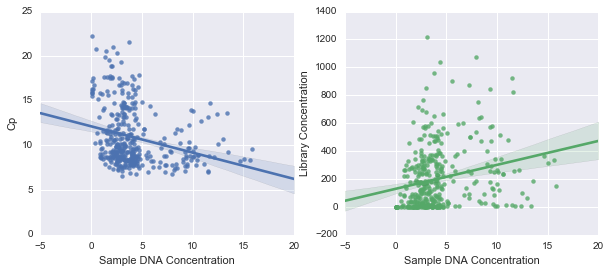

In [289]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.regplot(x="Sample DNA Concentration", y="Cp", data=plate_df, ax = ax1);
sns.regplot(x="Sample DNA Concentration", y="Library Concentration", data=plate_df, ax = ax2);

### Library concentration heatmap, whole plate

In [292]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="Library Concentration", well_col='Well').astype(float)
vols = make_2D_array(plate_df, data_col='Pooled Volume', well_col='Well').astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col='Well').astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col='Well')
i5 = make_2D_array(plate_df, data_col='i5 name', well_col='Well')
i7 = make_2D_array(plate_df, data_col='i7 name', well_col='Well')

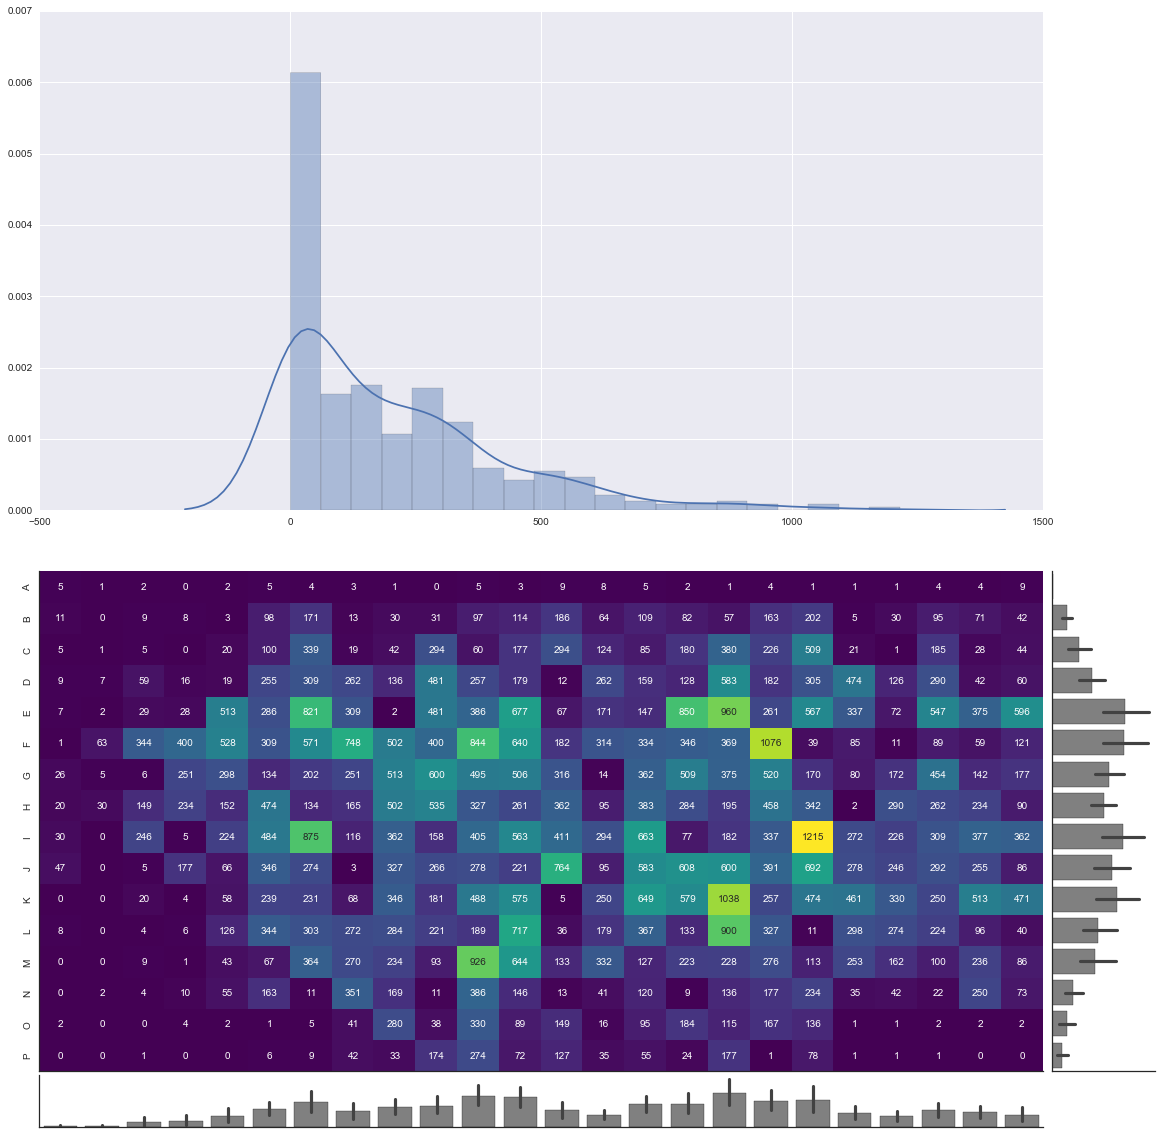

In [293]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

In [294]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### Library concentration heatmap, Plate 1

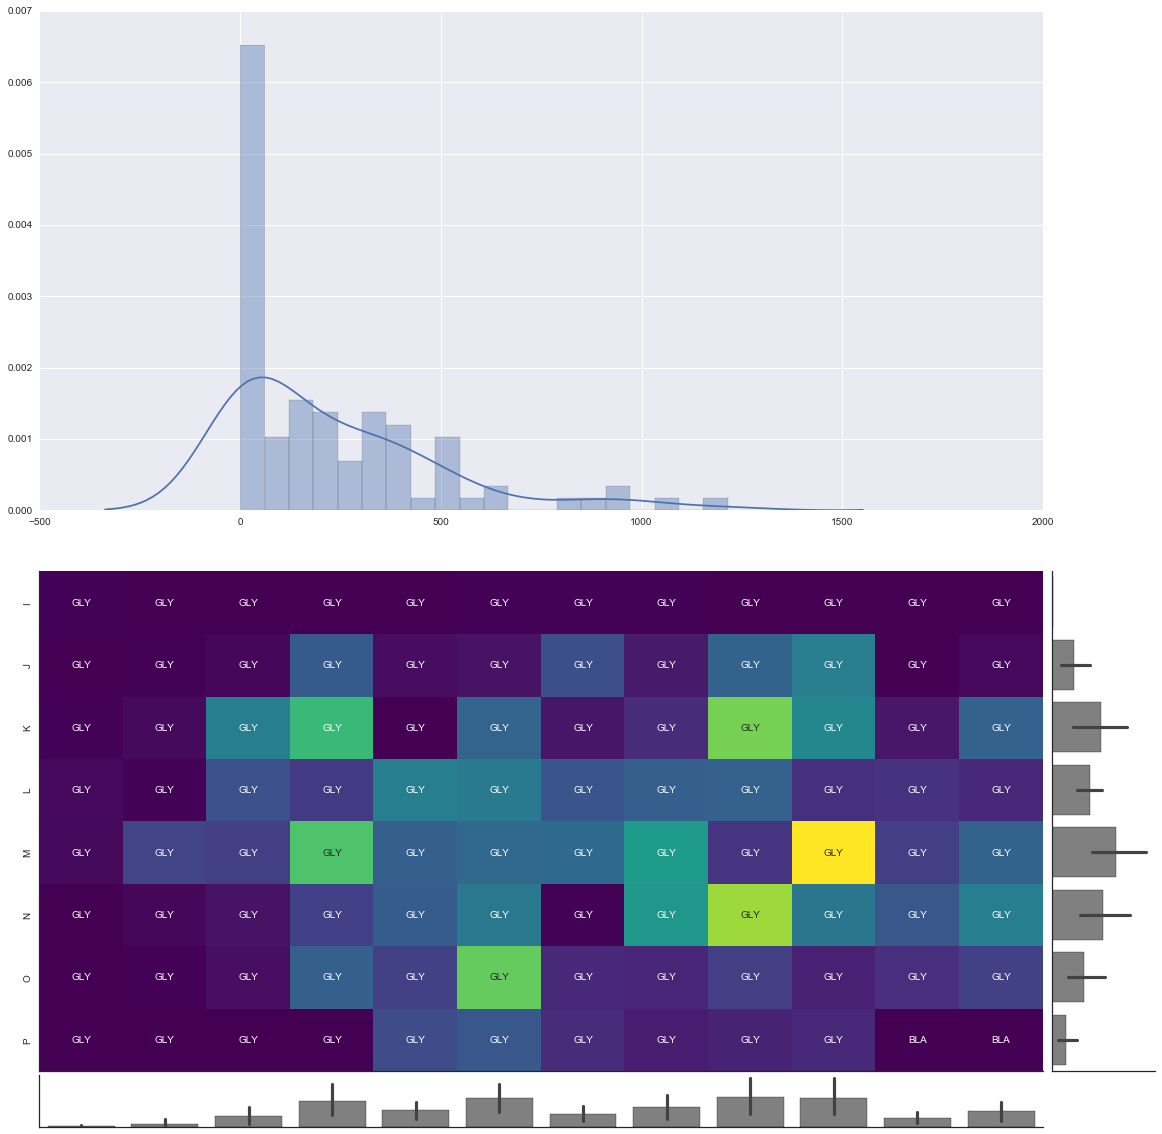

In [295]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='.3s')

### Library concentration heatmap, Plate 2

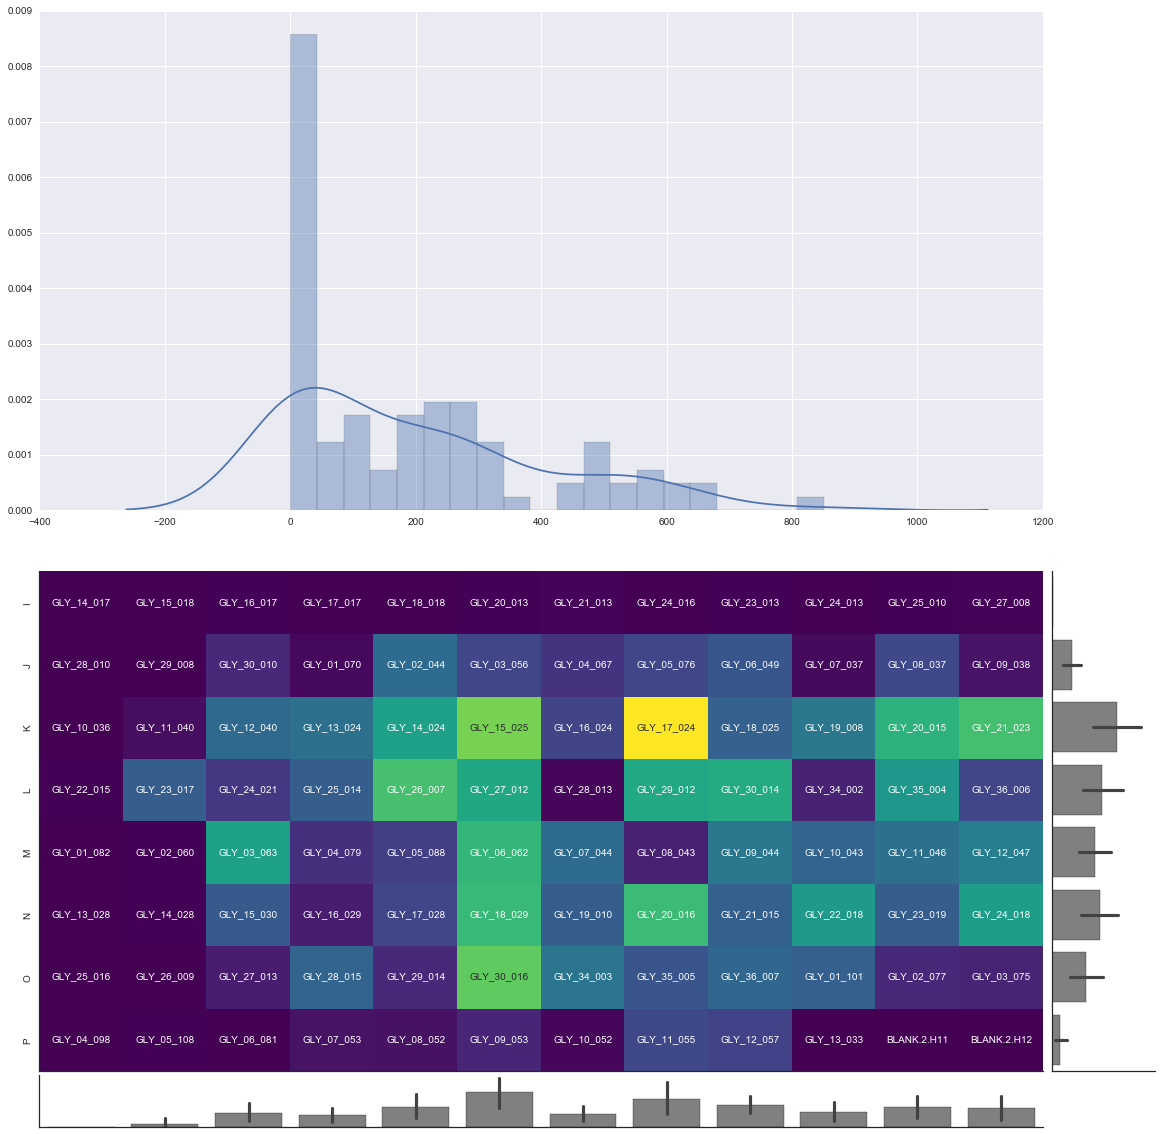

In [296]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 3

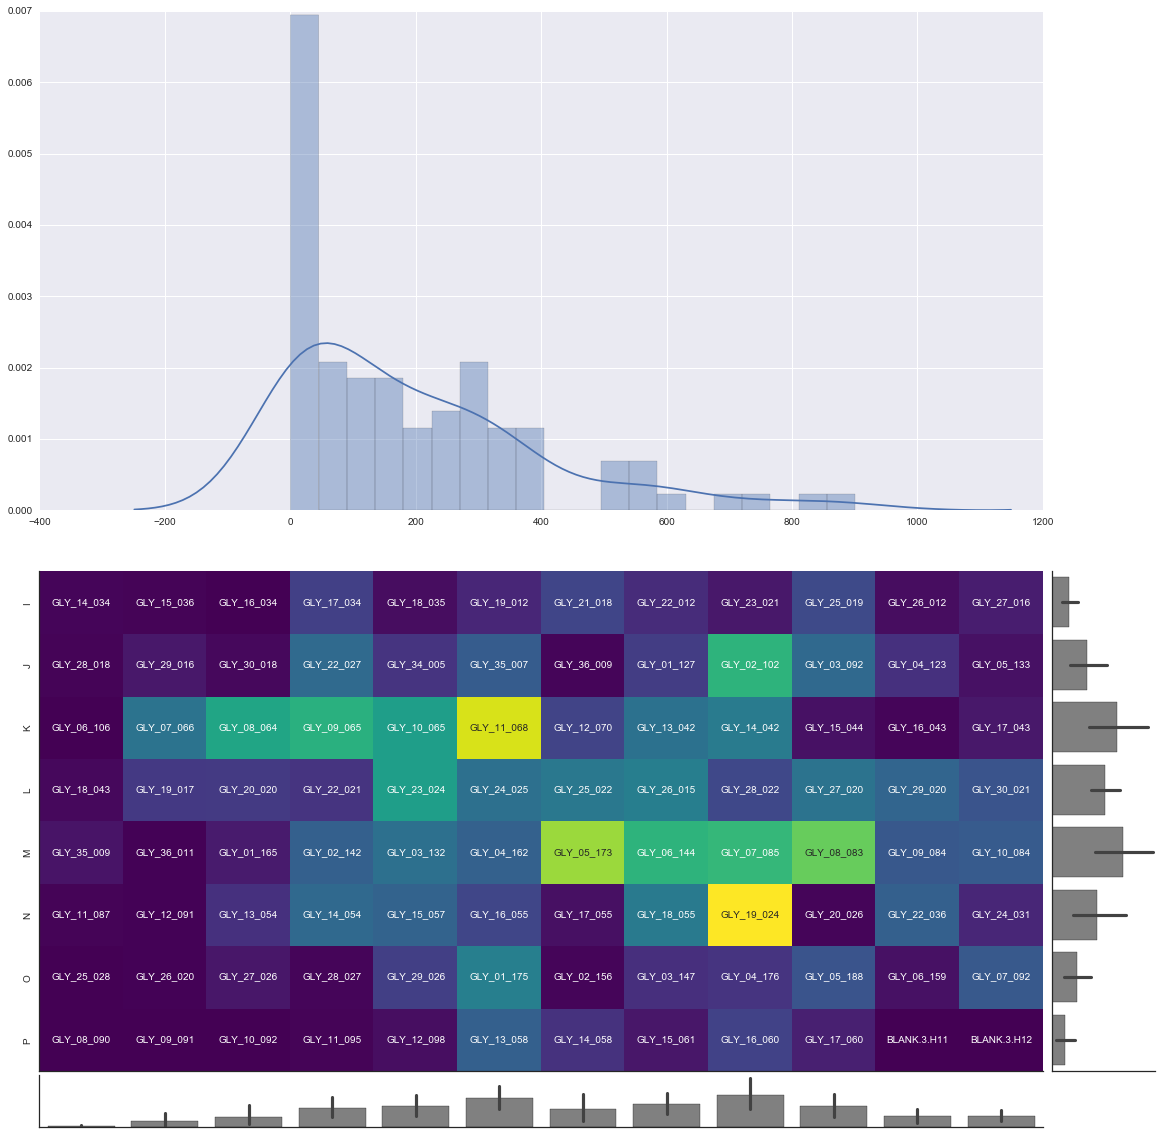

In [297]:
plot_plate_vals(concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 4

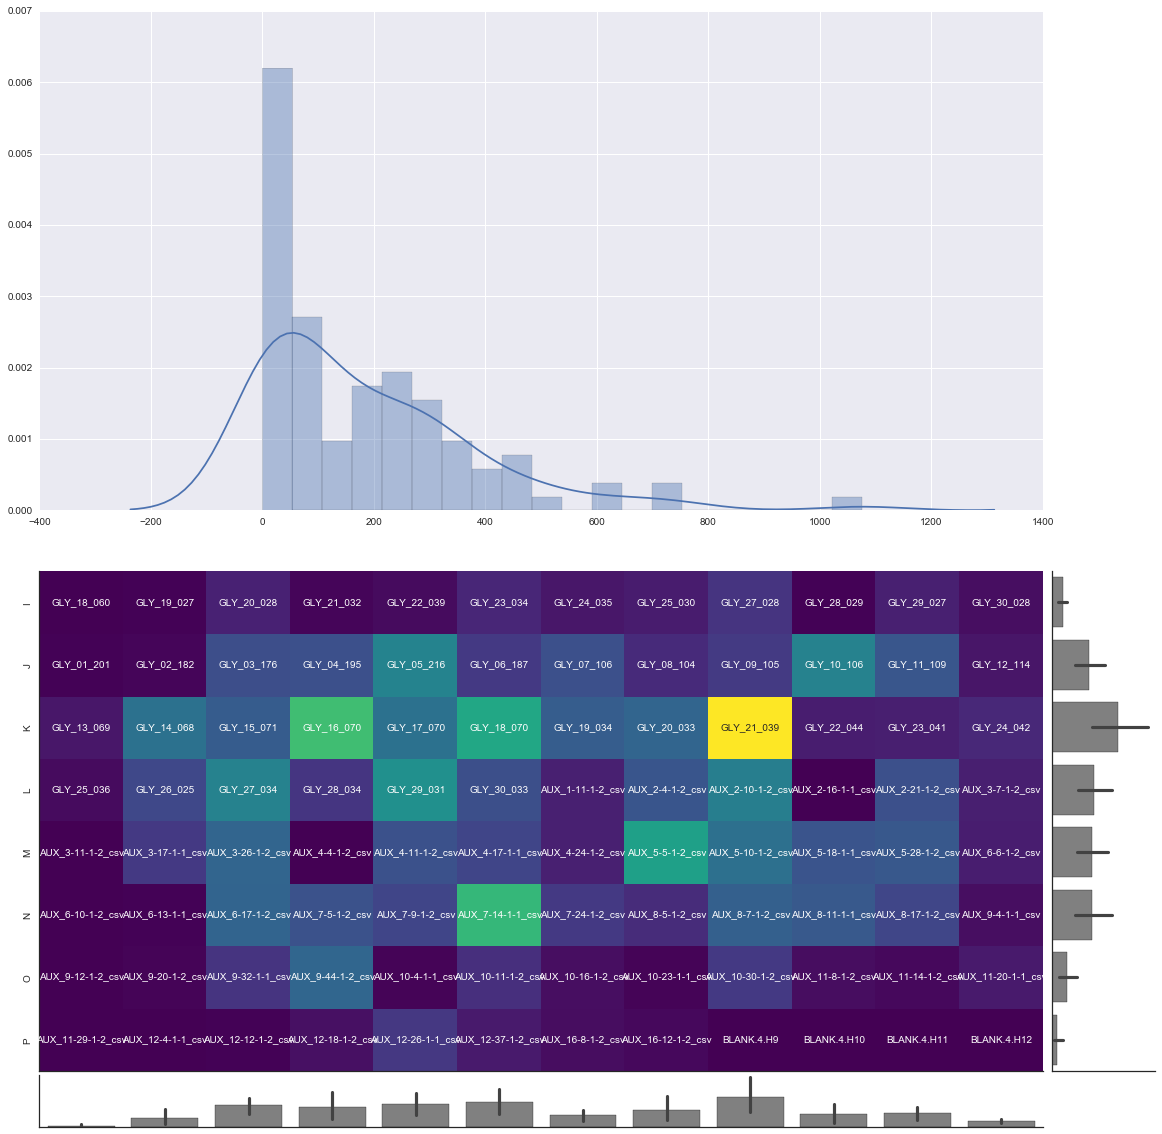

In [298]:
plot_plate_vals(concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Plot pooling volumes

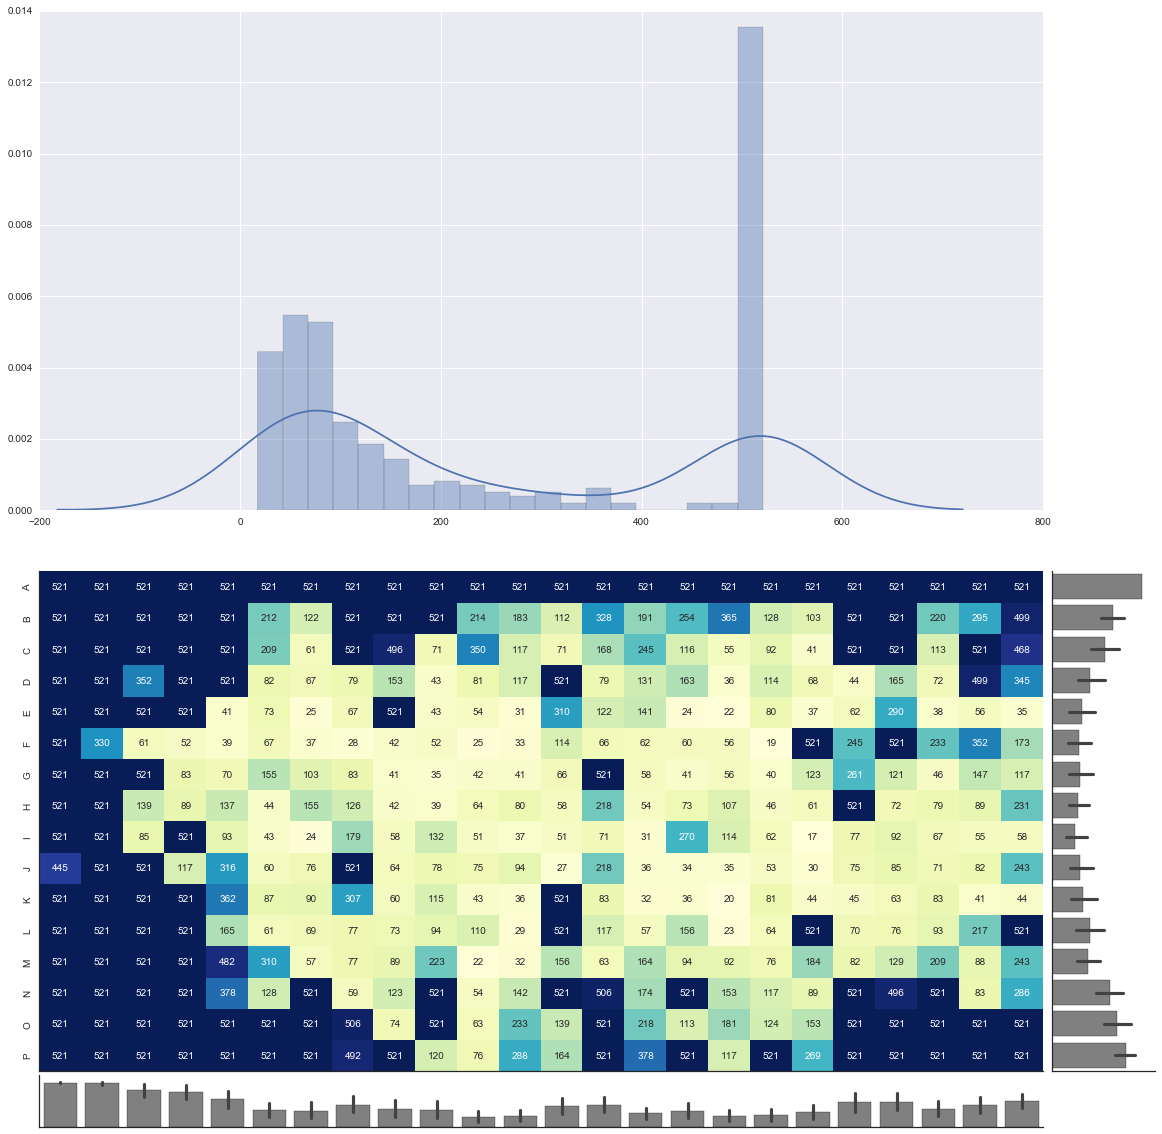

In [299]:
plot_plate_vals(vols)

## Step 6: write pooling pick list

In [300]:
# Write the picklist
picklist_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_qPCR_pooling_picklist.txt'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [301]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)
print(picklist)

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2_HT,A1,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A2,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A3,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A4,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A5,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A6,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A7,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A8,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A9,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A10,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A11,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A12,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A13,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A14,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A15,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A16,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A17,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A18,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A19,,520.83,NormalizedDNA,A